In [5]:
#Initialize SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CreditRiskAnalysis") \
    .getOrCreate()

#Load the CSV data into a Spark DataFrame
data_path = "/Users/tanvirsmac/Downloads/ComputerScience/3rd_Year/2nd semester/CSCI316/GP/data.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest

25/05/19 18:24:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+--------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+

In [6]:
#Total number of records (rows)
total_count = df.count()
print(f"Total number of loans: {total_count}")

#Number of columns
num_cols = len(df.columns)
print(f"Number of columns: {num_cols}")

#Summary statistics for numeric columns
df.describe().show()


Total number of loans: 855969
Number of columns: 73


+-------+--------------------+--------------------+------------------+------------------+------------------+----------+------------------+------------------+------+---------+--------------------+----------+--------------+-----------------+-------------------+---------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+----------------------+----------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-----------------+--------------------+--------------------+------------------+--------------------+-----------------+-----------------------+------------------+-----------------+------------------+------------------+--------------------------+---------------------------+------------------+-----------------+----------------

In [7]:
from pyspark.sql.functions import col, sum

# Count missing (null) values in each column
missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+----------+------+-------+-----+--------+----------+---+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-----------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_

In [8]:
# Drop columns that are not useful for analysis
cols_to_drop = ["id", "member_id", "desc", "url", "title"]  # IDs, descriptions, URLs
df = df.drop(*[c for c in cols_to_drop if c in df.columns])

# Fill missing values for certain columns
# Example: employment length (emp_length) - fill null with '0 years' indicating no info
if 'emp_length' in df.columns:
    df = df.fillna({'emp_length': '0 years'})
# Example: months since last delinquency - fill null with 0 (meaning no delinquency on record)
if 'mths_since_last_delinq' in df.columns:
    df = df.fillna({'mths_since_last_delinq': 0})

In [9]:
# Calculate class distribution of default_ind
df.groupBy('default_ind').count().show()


+-----------+------+
|default_ind| count|
+-----------+------+
|       NULL|   223|
|          1| 46436|
|          0|809310|
+-----------+------+



In [10]:
result = df.groupBy('default_ind').count().collect()
total = result[0]['count'] + result[1]['count']
rate_default = result[1]['count'] / total * 100
print(f"Default rate: {rate_default:.2f}%")


Default rate: 99.52%


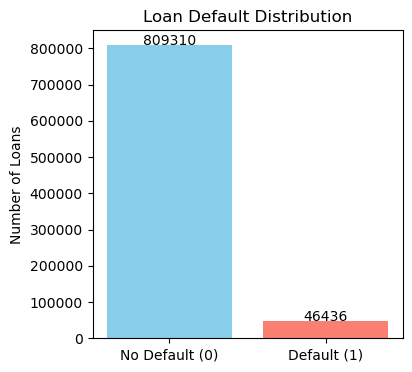

In [11]:
# Get counts for plotting
counts = {row['default_ind']: row['count'] for row in result}
classes = ['No Default (0)', 'Default (1)']
values = [counts.get(0, 0), counts.get(1, 0)]

import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.bar(classes, values, color=['skyblue','salmon'])
plt.title("Loan Default Distribution")
plt.ylabel("Number of Loans")
for i, val in enumerate(values):
    plt.text(i, val + 500, str(val), ha='center')  # annotate counts
plt.show()


In [12]:
from pyspark.sql.functions import mean, stddev, expr

# compute average values of some numeric features grouped by default status
df.groupBy('default_ind').agg(
    mean('loan_amnt').alias('avg_loan_amnt'),
    mean('int_rate').alias('avg_int_rate'),
    mean('annual_inc').alias('avg_annual_inc'),
    mean('dti').alias('avg_dti')
).show()


+-----------+------------------+------------------+-----------------+------------------+
|default_ind|     avg_loan_amnt|      avg_int_rate|   avg_annual_inc|           avg_dti|
+-----------+------------------+------------------+-----------------+------------------+
|       NULL|11714.349775784753|12.194529147982067|75596.20036036035|              NULL|
|          1|14574.475083986563|16.020520070634642|65131.56913816867| 18.44807059482276|
|          0|14756.223604057777|13.030320112192333|75641.39585116955|18.105205724883753|
+-----------+------------------+------------------+-----------------+------------------+



In [13]:
from pyspark.sql.functions import expr, count

df.groupBy('term').agg(expr("mean(default_ind) as default_rate"), count("*").alias("count")).show()



+----------+--------------------+------+
|      term|        default_rate| count|
+----------+--------------------+------+
| 36 months|0.049613842343678646|600221|
| 60 months| 0.06517369746453318|255748|
+----------+--------------------+------+



In [14]:
df.groupBy('grade').agg(expr("mean(default_ind) as default_rate"), count("*").alias("count")).orderBy("grade").show()


+-----+--------------------+------+
|grade|        default_rate| count|
+-----+--------------------+------+
|    A|0.018287197588259935|145665|
|    B| 0.03916245825198858|247998|
|    C|0.054875216418225584|236855|
|    D| 0.08126021495657937|132802|
|    E| 0.09716410271848752| 66448|
|    F| 0.14125592083665525| 21328|
|    G|  0.1669061794292753|  4873|
+-----+--------------------+------+



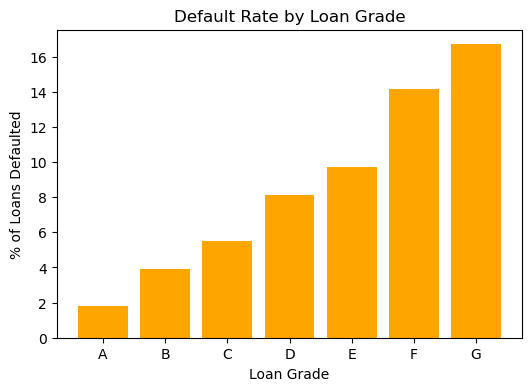

In [15]:
# Collect default rates by grade for plotting
grade_stats = df.groupBy('grade').agg(expr("mean(default_ind) as default_rate")).orderBy("grade").collect()
grades = [row['grade'] for row in grade_stats]
default_rates = [row['default_rate'] for row in grade_stats]

plt.figure(figsize=(6,4))
plt.bar(grades, [r*100 for r in default_rates], color='orange')
plt.title("Default Rate by Loan Grade")
plt.xlabel("Loan Grade")
plt.ylabel("% of Loans Defaulted")
plt.show()


In [16]:
df.groupBy('home_ownership').agg(expr("mean(default_ind) as default_rate"), count("*").alias("count")).show()


+--------------+--------------------+------+
|home_ownership|        default_rate| count|
+--------------+--------------------+------+
|           OWN|0.049109584155590955| 84136|
|          RENT| 0.06397425376512401|342535|
|      MORTGAGE| 0.04746898141565486|429105|
|         OTHER|              0.1875|   144|
|          NONE| 0.15555555555555556|    45|
|           ANY|                 0.0|     3|
|       2 years|                NULL|     1|
+--------------+--------------------+------+



In [17]:
df.groupBy('purpose').agg(expr("mean(default_ind) as default_rate"), count("*").alias("count")).orderBy("default_rate", ascending=False).show(10)


+--------------------+-------------------+-----+
|             purpose|       default_rate|count|
+--------------------+-------------------+-----+
| so that our comp...|                1.0|    1|
|          550 amount|                1.0|    1|
|         educational|0.17088607594936708|  316|
|      small_business|0.14133442656554268| 9757|
|             wedding|0.11638120333772507| 2277|
|    renewable_energy|0.09836065573770492|  549|
|              moving|0.08451250242295018| 5159|
|               house|0.08352337514253136| 3508|
|               other|0.07325416605580805|40926|
|             medical|0.07107962872496336| 8188|
+--------------------+-------------------+-----+
only showing top 10 rows



In [18]:
from pyspark.sql.functions import col

numeric_cols = ['int_rate','loan_amnt','dti','annual_inc','revol_util','open_acc','delinq_2yrs']
for colname in numeric_cols:
    df = df.withColumn(colname, col(colname).cast('double'))  # or 'int' if you prefer


In [15]:
for col_name in numeric_cols:
    corr_val = df.stat.corr(col_name, 'default_ind')
    print(f"Correlation between {col_name} and default_ind = {corr_val:.3f}")


Correlation between int_rate and default_ind = 0.155
Correlation between loan_amnt and default_ind = -0.005
Correlation between dti and default_ind = 0.005
Correlation between annual_inc and default_ind = -0.037
Correlation between revol_util and default_ind = 0.005
Correlation between open_acc and default_ind = -0.022
Correlation between delinq_2yrs and default_ind = -0.009


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

#  Start Spark session
spark = SparkSession.builder \
    .appName("CreditRiskPreprocessing") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Load data
df = spark.read.csv("C:/Users/talha/Downloads/CSCI316_Project/data.csv", header=True, inferSchema=True)

# Drop rows with NULL default_ind
df = df.filter(df['default_ind'].isNotNull())

# List of features
feature_cols = [
    "loan_amnt", "term", "int_rate", "grade", "sub_grade", "home_ownership",
    "annual_inc", "verification_status", "purpose", "dti", "delinq_2yrs",
    "inq_last_6mths", "open_acc", "pub_rec", "revol_util", "emp_length"
]
feature_cols = [c for c in feature_cols if c in df.columns]

# 5. Cast label to double
df = df.withColumn("label", col("default_ind").cast("double"))

# 6. Identify categorical columns
categorical_cols = ["term", "grade", "sub_grade", "home_ownership", "verification_status", "purpose", "emp_length"]
categorical_cols = [c for c in categorical_cols if c in feature_cols]

# 7. StringIndexer for categorical features using Pipeline
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid='keep') for c in categorical_cols]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

# 8. Prepare the list of final features (categorical replaced by *_index)
feature_cols_final = []
for c in feature_cols:
    if c in categorical_cols:
        feature_cols_final.append(c + "_index")
    else:
        feature_cols_final.append(c)

# 9. Cast all features to double
for c in feature_cols_final:
    df = df.withColumn(c, col(c).cast("double"))

# 10. Fill nulls in feature columns
df = df.fillna(0, subset=feature_cols_final)

# 11. Assemble features 
assembler = VectorAssembler(inputCols=feature_cols_final, outputCol="features")
df = assembler.transform(df)

# 12. Select columns to save
save_cols = feature_cols_final + ["label"]  # Just features and label

# 13. Save as CSV (folder will be created, can delete/overwrite if exists)
output_path = "C:/Users/talha/Downloads/CSCI316_Project/preprocessed_data_csv"
df.select(save_cols).write.mode("overwrite").csv(output_path, header=True)

print("Preprocessing complete and data saved as CSV!")


Preprocessing complete and data saved as CSV!
